<a href="https://colab.research.google.com/github/alessandro-rubin/databricks_training/blob/main/Databricks_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructType, StructField, TimestampType
import random
import datetime

# Create a Spark session
spark = SparkSession.builder.appName("ColabSparkSession").getOrCreate()

# Define the schema for the DataFrame
schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("VIN", StringType(), True),
    StructField("odometer", DoubleType(), True),
    StructField("rail_pressure", DoubleType(), True)
])

# Generate random data for each VIN
num_vins = 10
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 1, 8)
interval = datetime.timedelta(seconds=60)

data = []
for vin_index in range(num_vins):
    vin = f"VIN_{vin_index}"
    start_odometer = random.uniform(1000, 2000)
    end_odometer = random.uniform(start_odometer, start_odometer + 1000)
    avg_pressure = random.uniform(5, 7)
    
    current_date = start_date
    while current_date <= end_date:
        data.append((current_date, vin, start_odometer, random.gauss(avg_pressure, 2)))
        current_date += interval
        start_odometer += (end_odometer - start_odometer) / ((end_date - start_date).total_seconds() / 60)

# Create the DataFrame
df = spark.createDataFrame(data, schema)

# Show the DataFrame
df.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=01c52631db006290faf906f94e0a15038a92ee4f78602639d677f182fbfe2b7e
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
+-------------------+-----+------------------+------------------+
|          timestamp|  VIN|          odometer|     rail_pressure|
+-------------------+-----+------------------+------------------+
|2023-01-01 00:00:00|VIN_0|1288.1650245655894|6.7698048931673505|
|2023-01-01 00:01:00|VIN_0|1288.2627155407172| 6.793048261725837|
|2023-01-01 00:02:00|VIN_0|1288.3603968242799| 4.063238854402654|
|2023-01-01 00:03:00|VIN_0| 1288.458068417239| 6.769930819675867|
|2023-01-01 00:04:00|VI

In [ ]:
# Calculate quantiles and median for rail pressure and odometer
quantiles_df = df.groupBy('VIN').agg(
    expr('percentile(rail_pressure, array(0.01, 0.99))').alias('rail_pressure_quantiles'),
    expr('percentile(odometer, 0.5)').alias('median_odometer')
)

# Join quantiles_df with the original DataFrame
df_with_quantiles = df.join(quantiles_df, 'VIN')

# Show the updated DataFrame
df_with_quantiles.show()

In [ ]:
from pyspark.sql.functions import expr
quantiles = df.groupBy("VIN").agg(expr("percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))"))
quantiles.show()

+-----+--------------------------------------------------------+
|  VIN|percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))|
+-----+--------------------------------------------------------+
|VIN_2|                                    [3.66585171286694...|
|VIN_3|                                    [2.41653835012601...|
|VIN_1|                                    [2.11621256772665...|
|VIN_0|                                    [3.36801837893917...|
|VIN_4|                                    [2.22361345229707...|
|VIN_5|                                    [1.71516047156278...|
|VIN_6|                                    [3.43125567976242...|
|VIN_9|                                    [1.83105565781033...|
|VIN_7|                                    [2.59243835528906...|
|VIN_8|                                    [1.81752788791207...|
+-----+--------------------------------------------------------+



In [ ]:
quantiles.collect()

[Row(VIN='VIN_2', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[3.6658517128669414, 6.889949311664074, 10.212720812975995]),
 Row(VIN='VIN_3', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[2.4165383501260145, 5.769674311056548, 9.07447720483185]),
 Row(VIN='VIN_1', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[2.1162125677266586, 5.330064239720522, 8.644406235944093]),
 Row(VIN='VIN_0', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[3.3680183789391718, 6.675346067736175, 9.979141904642987]),
 Row(VIN='VIN_4', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[2.2236134522970774, 5.462967473408014, 8.772501914347231]),
 Row(VIN='VIN_5', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[1.71516047156278, 5.00599593477565, 8.301375143157031]),
 Row(VIN='VIN_6', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[3.4312556797624265, 6.680232162652408, 9.975349258433337]),
 Row(VIN='VIN_9', percentile_approx(rail_pressure, 

In [ ]:
pandas_df

,timestamp,VIN,odometer,rail_pressure
0,2023-01-01 00:00:00,VIN_0,1288.165025,6.769805
1,2023-01-01 00:01:00,VIN_0,1288.262716,6.793048
2,2023-01-01 00:02:00,VIN_0,1288.360397,4.063239
3,2023-01-01 00:03:00,VIN_0,1288.458068,6.769931
4,2023-01-01 00:04:00,VIN_0,1288.555730,8.411989
...,...,...,...,...
100805,2023-01-07 23:56:00,VIN_9,1550.696043,7.909959
100806,2023-01-07 23:57:00,VIN_9,1550.716042,6.104645
100807,2023-01-07 23:58:00,VIN_9,1550.736039,3.691233
100808,2023-01-07 23:59:00,VIN_9,1550.756034,1.065586


In [ ]:
import seaborn as sns

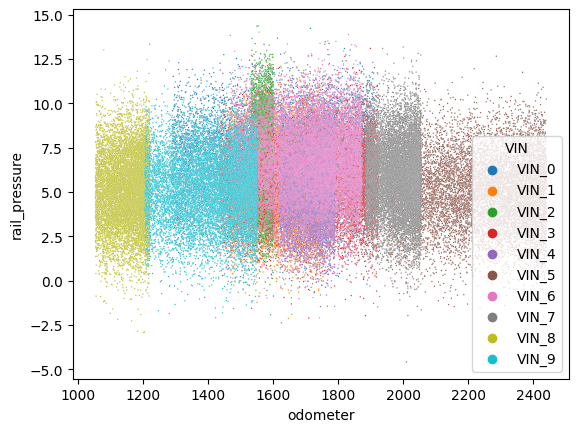

In [ ]:
sns.scatterplot(data=pandas_df, x='odometer',y='rail_pressure', hue='VIN',s=1)
plt.show()